# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import cvxpy as cp
import numpy as np
import time
from tqdm import tqdm

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

In [4]:
try_old_20 = []
try_new_20 = []
try_old_50 = []
try_new_50 = []
try_old_100 = []
try_new_100 = []
try_old_500 = []
try_new_500 = []
try_old_1000 = []
try_new_1000 = []

for i in tqdm(range(100)):
    n = 10
    selected_X, selected_y = select_n_points(data_X, data_y, n)
    scaler = StandardScaler()
    selected_X = scaler.fit_transform(selected_X)
    
    # solve the SVM problem
    w = cp.Variable(2)
    b = cp.Variable(1)
    objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)
    constraints = [
        cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver='SCS')
    
    g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
    g_SCS = jnp.array(g).flatten()
    
    nw = selected_X.shape[1]
    nb = 1
    nx = nw + nb
    nu = selected_X.shape[0]
    NY = nx+nu
    
    xu0 = jnp.zeros(NY)
    xu0 = xu0.at[:nw + nb].set(1.0)

    def constraints_diff(g_ODE, g_SCS):
        return jnp.abs(g_ODE - g_SCS).max()
    
    # define the ODE problems
    def f(x):
        w = x[:-1]
        output = (1/2) * jnp.linalg.norm(w, 2)**2
        return output

    def g(x):
        w = x[:nw]
        b = x[nw]
        
        g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
        output = jnp.array(g)
        return output
    
    def P(xu): # projection mapping
        return xu
    
    # new ODE
    Q = jnp.eye(nx)
    Q = Q.at[-1, -1].set(0.0)

    B = jnp.zeros((nu, nx))
    for i in range(nu):
        row = -selected_y[i] * jnp.hstack((selected_X[i], jnp.array([1.0])))
        B = B.at[i].set(row)

    d = - jnp.ones(nu)

    def ODE_new(t, xu):
        x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

        dx = - (Q @ x + B.T @ jnp.clip(u + B @ x - d, a_min=0))
        du = - u / 2 + jnp.clip(u + B @ x - d, a_min=0) / 2
        dxu = jnp.concatenate([dx, du], axis=0)
        return dxu

    ODE_new = jit(ODE_new)
    
    # old ODE
    df = fgrad(f) # jacobian of f
    dg = jacrev(g) # jacobian of g

    def ODE_old(t, xu):
        x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

        dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
        dx = -dx
        du = -u + jnp.clip(u+g(x), a_min=0)
        du = 0.5*du
        dxu = jnp.concatenate([dx, du], axis=0)
        return dxu

    ODE_old = jit(ODE_old)
    
    def solve_ODE(xu0, T):
        # old ODE
        sol_old = solve_ivp(ODE_old, [0., T], xu0, t_eval=np.arange(0, T, 0.01), method=NUMERICAL_METHOD)
        result_old = P(sol_old.y[:, -1])
        const_unsatified_old = len([i for i in g(result_old[:nx]) if i>0])
        const_diff_old = constraints_diff(g(result_old[:nx]), g_SCS)
        const_diff_old_max = const_diff_old.max()
        const_diff_old_mean = const_diff_old.mean()
        res_diff_old= jnp.concatenate([jnp.abs(result_old[:nw] - w.value), jnp.abs(result_old[nw] - b.value)])
        res_diff_old_mean = res_diff_old.mean()
        
        # new ODE
        sol_new = solve_ivp(ODE_new, [0., T], xu0, t_eval=np.arange(0, T, 0.01), method=NUMERICAL_METHOD)
        result_new = P(sol_new.y[:, -1])
        const_unsatified_new = len([i for i in g(result_new[:nx]) if i>0])
        const_diff_new = constraints_diff(g(result_new[:nx]), g_SCS)
        const_diff_new_max = const_diff_new.max()
        const_diff_new_mean = const_diff_new.mean()
        res_diff_new = jnp.concatenate([jnp.abs(result_new[:nw] - w.value), jnp.abs(result_new[nw] - b.value)])
        res_diff_new_mean = res_diff_new.mean()
        return {
                    'const_unsatified': const_unsatified_old,
                    'const_diff_max': const_diff_old_max,
                    'const_diff_mean': const_diff_old_mean,
                    'res_diff_mean': res_diff_old_mean
                }, {
                    'const_unsatified': const_unsatified_new,
                    'const_diff_max': const_diff_new_max,
                    'const_diff_mean': const_diff_new_mean,
                    'res_diff_mean': res_diff_new_mean
                }
    
    # solve the ODE problem
    old_20, new_20 = solve_ODE(xu0, 20)
    old_50, new_50 = solve_ODE(xu0, 50)
    old_100, new_100 = solve_ODE(xu0, 100)
    old_500, new_500 = solve_ODE(xu0, 500)
    old_1000, new_1000 = solve_ODE(xu0, 1000)
    
    try_old_20.append(old_20)
    try_new_20.append(new_20)
    try_old_50.append(old_50)
    try_new_50.append(new_50)
    try_old_100.append(old_100)
    try_new_100.append(new_100)
    try_old_500.append(old_500)
    try_new_500.append(new_500)
    try_old_1000.append(old_1000)
    try_new_1000.append(new_1000)
    

100%|██████████| 100/100 [1:15:26<00:00, 45.26s/it]


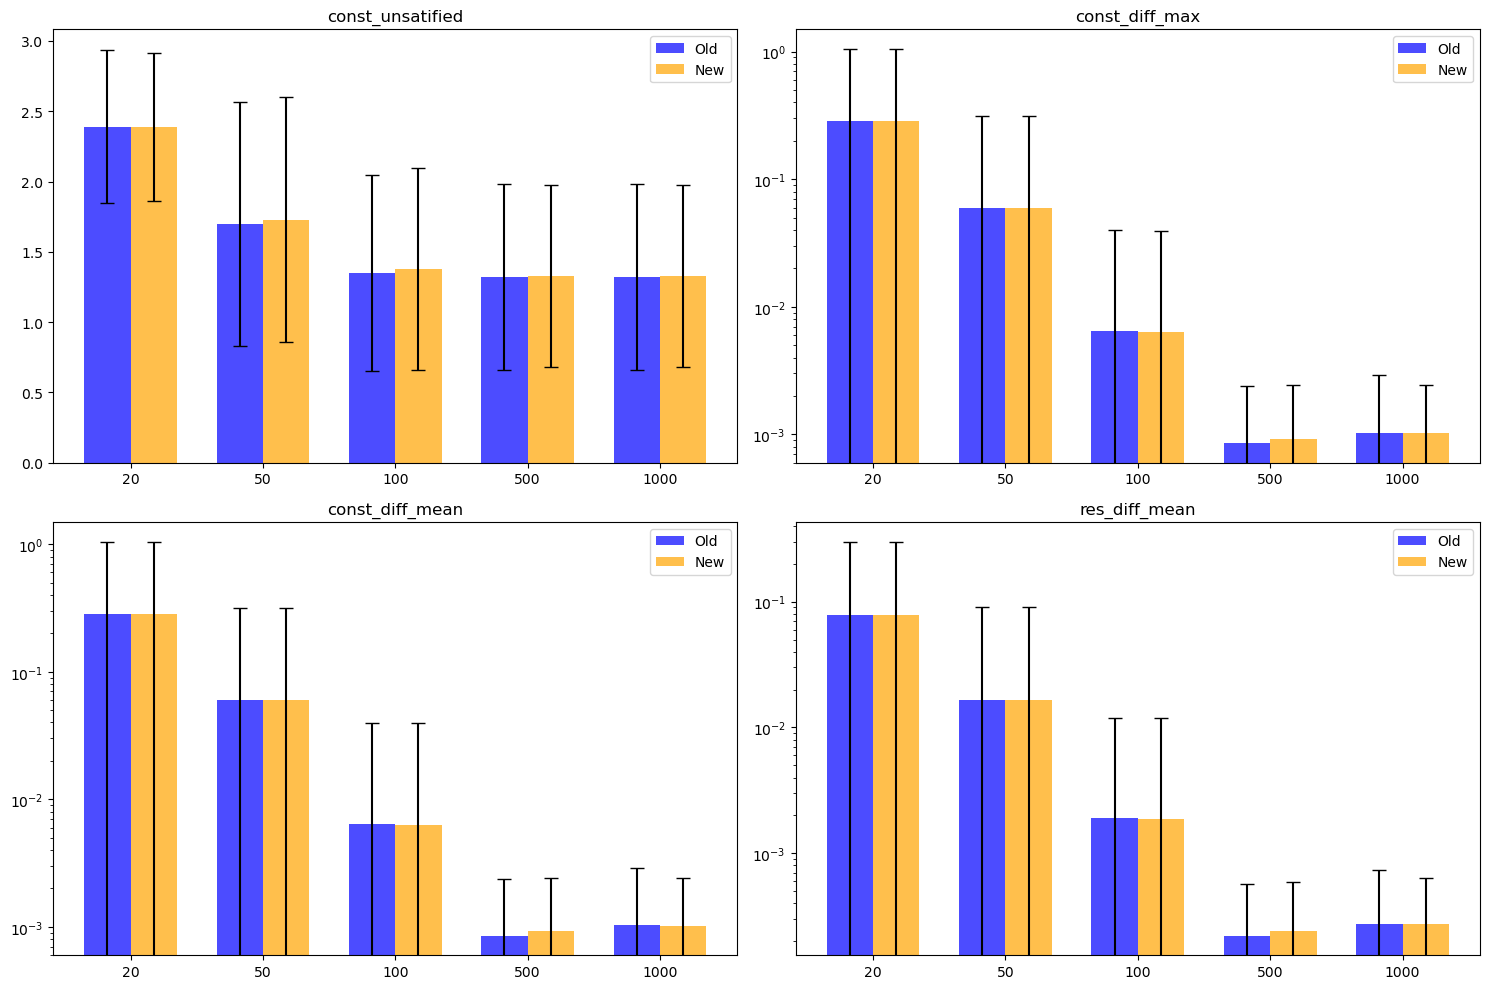

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def extract_values_stats(old_list, new_list, key):
    old_values = [item[key].item() if hasattr(item[key], 'item') else item[key] for item in old_list]
    new_values = [item[key].item() if hasattr(item[key], 'item') else item[key] for item in new_list]
    return (np.mean(old_values), np.std(old_values)), (np.mean(new_values), np.std(new_values))

# Values to plot
values = [20, 50, 100, 500, 1000]

# Keys to plot
keys = ['const_unsatified', 'const_diff_max', 'const_diff_mean', 'res_diff_mean']

# Lists containing the data
lists_old = [try_old_20, try_old_50, try_old_100, try_old_500, try_old_1000]
lists_new = [try_new_20, try_new_50, try_new_100, try_new_500, try_new_1000]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

# Width of bars
width = 0.35

for idx, key in enumerate(keys):
    old_stats = []
    new_stats = []
    
    for old_list, new_list in zip(lists_old, lists_new):
        old_stat, new_stat = extract_values_stats(old_list, new_list, key)
        old_stats.append(old_stat)
        new_stats.append(new_stat)
    
    x = np.arange(len(values))
    
    # Extract means and stds
    old_means = [stat[0] for stat in old_stats]
    old_stds = [stat[1] for stat in old_stats]
    new_means = [stat[0] for stat in new_stats]
    new_stds = [stat[1] for stat in new_stats]
    
    # Plot bars with error bars
    axs[idx].bar(x - width/2, old_means, width, yerr=old_stds, label='Old', color='blue', 
                 capsize=5, alpha=0.7, error_kw={'ecolor': 'black', 'capthick': 1})
    axs[idx].bar(x + width/2, new_means, width, yerr=new_stds, label='New', color='orange', 
                 capsize=5, alpha=0.7, error_kw={'ecolor': 'black', 'capthick': 1})
    
    axs[idx].set_title(key)
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(values)
    
    # Set y-axis to logarithmic scale for all keys except 'const_unsatified'
    if key != 'const_unsatified':
        axs[idx].set_yscale('log')
    
    axs[idx].legend()

plt.tight_layout()
plt.show()